In [8]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [24]:
voice = pd.read_csv("voice.csv", header=0)
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [25]:
le = preprocessing.LabelEncoder()
voice["label"] = le.fit_transform(voice["label"])
le.classes_

array(['female', 'male'], dtype=object)

In [28]:
train, test = train_test_split(voice, test_size=0.3)

trainFeatures = train.iloc[:, :-1]
trainLabel = train["label"]
testFeatures = test.iloc[:, :-1]
testLabel = test["label"]

trainLabel=pd.get_dummies(trainLabel)
testLabel=pd.get_dummies(testLabel)
trainLabel.head()

,0,1
681,0,1
1293,0,1
2234,1,0
2015,1,0
2686,1,0


### All Features Model

In [33]:
def create_train_model(hidden_nodes,iters):
    #重置图形
    tf.reset_default_graph()
    #定义占位符
    x=tf.placeholder(shape=(2217,20),dtype=tf.float64,name='x')
    y=tf.placeholder(shape=(2217,2),dtype=tf.float64,name='y')
    #定义weights
    w1=tf.Variable(np.random.rand(20,hidden_nodes),dtype=tf.float64)
    w2=tf.Variable(np.random.rand(hidden_nodes,2),dtype=tf.float64)
    #创建神经网络图
    a1=tf.sigmoid(tf.matmul(x,w1))
    pred_y=tf.sigmoid(tf.matmul(a1,w2))
    #cost function
    delta=tf.square(pred_y-y)
    loss=tf.reduce_sum(delta)
    #定义最小化损失函数的训练操作
    optimizer=tf.train.GradientDescentOptimizer(0.005)
    train=optimizer.minimize(loss)
    #初始化变量并运行会话
    init=tf.global_variables_initializer()
    sess=tf.Session()
    sess.run(init)
    #Iteration
    for i in range(iters):
        sess.run(train,feed_dict={x:trainFeatures,y:trainLabel})
        loss_plot[hidden_nodes].append(sess.run(loss,feed_dict={
            x:trainFeatures.as_matrix(),y:trainLabel.as_matrix()}))
        weights1=sess.run(w1)
        weights2=sess.run(w2)
    print('loss(hidden nodes: %d, iterations: %d): %.2f'
         %(hidden_nodes,iters,loss_plot[hidden_nodes][-1]))
    return weights1,weights2

loss(hidden nodes: 5, iterations: 2000): 1049.52
loss(hidden nodes: 10, iterations: 2000): 1262.82
loss(hidden nodes: 20, iterations: 2000): 2204.00


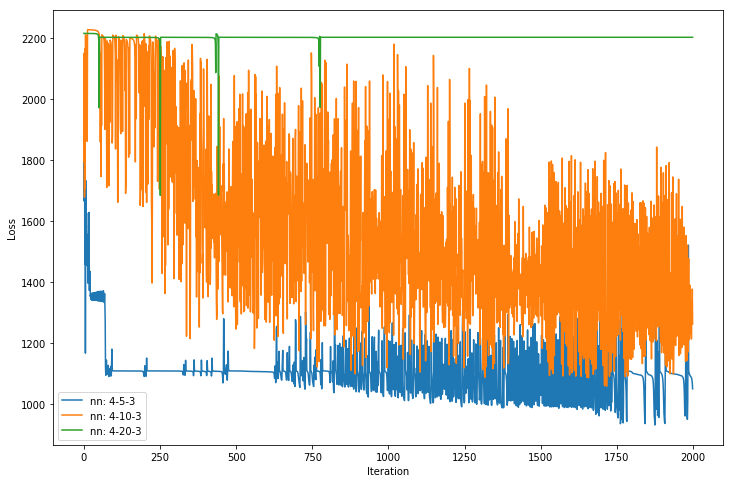

In [34]:
#创建三种神经网络：4-5-3,4-10-3,4-20-3
num_hidden_nodes=[5,10,20]
loss_plot={5:[],10:[],20:[]}
weights1={5:None,10:None,20:None}
weights2={5:None,10:None,20:None}
iters=2000
plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes],weights2[hidden_nodes]=create_train_model(hidden_nodes,iters)
    plt.plot(range(iters),
            loss_plot[hidden_nodes],
            label='nn: 4-%d-3'%hidden_nodes)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

In [38]:
x=tf.placeholder(shape=(951,20),dtype=tf.float64,name='x')
y=tf.placeholder(shape=(951,2),dtype=tf.float64,name='y')
for hidden_nodes in num_hidden_nodes:
    w1=tf.Variable(weights1[hidden_nodes])
    w2=tf.Variable(weights2[hidden_nodes])
    a1=tf.sigmoid(tf.matmul(x,w1))
    pred_y=tf.sigmoid(tf.matmul(a1,w2))
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        pred_y_np=sess.run(pred_y,feed_dict={x:testFeatures,y:testLabel})
    correct=[estimate.argmax(axis=0)==target.argmax(axis=0)
            for estimate,target in zip(pred_y_np,testLabel.as_matrix())]
    accuracy=100*sum(correct)/len(correct)
    print('Network architacture 4-%d-2, accuracy: %.2f%%'
         %(hidden_nodes,accuracy))  

Network architacture 4-5-2, accuracy: 60.46%
Network architacture 4-10-2, accuracy: 64.98%
Network architacture 4-20-2, accuracy: 49.32%


### Two Features Model

In [39]:
trainFeatures2 = train[["IQR","meanfun"]]
trainLabel2 = train["label"]
testFeatures2 = test[["IQR","meanfun"]]
testLabel2 = test["label"]

trainLabel2=pd.get_dummies(trainLabel2)
testLabel2=pd.get_dummies(testLabel2)
trainLabel2.head()

,0,1
681,0,1
1293,0,1
2234,1,0
2015,1,0
2686,1,0


In [42]:
def create_train_model(hidden_nodes,iters):
    #重置图形
    tf.reset_default_graph()
    #定义占位符
    x=tf.placeholder(shape=(2217,2),dtype=tf.float64,name='x')
    y=tf.placeholder(shape=(2217,2),dtype=tf.float64,name='y')
    #定义weights
    w1=tf.Variable(np.random.rand(2,hidden_nodes),dtype=tf.float64)
    w2=tf.Variable(np.random.rand(hidden_nodes,2),dtype=tf.float64)
    #创建神经网络图
    a1=tf.sigmoid(tf.matmul(x,w1))
    pred_y=tf.sigmoid(tf.matmul(a1,w2))
    #cost function
    delta=tf.square(pred_y-y)
    loss=tf.reduce_sum(delta)
    #定义最小化损失函数的训练操作
    optimizer=tf.train.GradientDescentOptimizer(0.005)
    train=optimizer.minimize(loss)
    #初始化变量并运行会话
    init=tf.global_variables_initializer()
    sess=tf.Session()
    sess.run(init)
    #Iteration
    for i in range(iters):
        sess.run(train,feed_dict={x:trainFeatures2,y:trainLabel2})
        loss_plot[hidden_nodes].append(sess.run(loss,feed_dict={
            x:trainFeatures2.as_matrix(),y:trainLabel2.as_matrix()}))
        weights1=sess.run(w1)
        weights2=sess.run(w2)
    print('loss(hidden nodes: %d, iterations: %d): %.2f'
         %(hidden_nodes,iters,loss_plot[hidden_nodes][-1]))
    return weights1,weights2

loss(hidden nodes: 5, iterations: 2000): 152.97
loss(hidden nodes: 10, iterations: 2000): 138.56
loss(hidden nodes: 20, iterations: 2000): 135.78


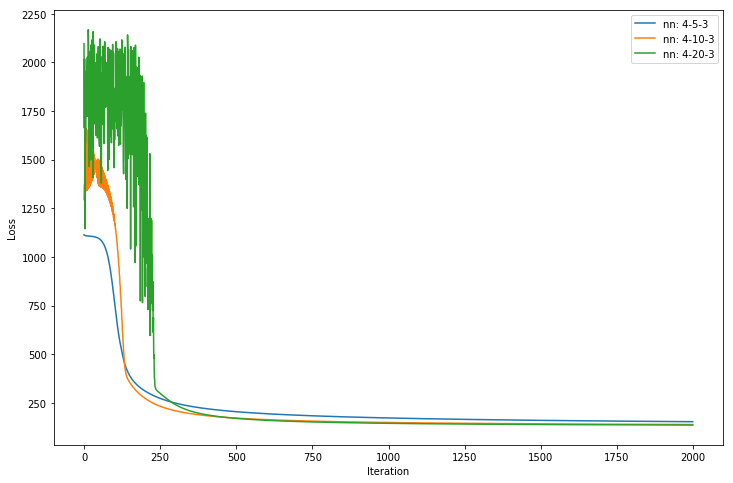

In [43]:
#创建三种神经网络：4-5-3,4-10-3,4-20-3
num_hidden_nodes=[5,10,20]
loss_plot={5:[],10:[],20:[]}
weights1={5:None,10:None,20:None}
weights2={5:None,10:None,20:None}
iters=2000
plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes],weights2[hidden_nodes]=create_train_model(hidden_nodes,iters)
    plt.plot(range(iters),
            loss_plot[hidden_nodes],
            label='nn: 4-%d-3'%hidden_nodes)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

In [45]:
x=tf.placeholder(shape=(951,2),dtype=tf.float64,name='x')
y=tf.placeholder(shape=(951,2),dtype=tf.float64,name='y')
for hidden_nodes in num_hidden_nodes:
    w1=tf.Variable(weights1[hidden_nodes])
    w2=tf.Variable(weights2[hidden_nodes])
    a1=tf.sigmoid(tf.matmul(x,w1))
    pred_y=tf.sigmoid(tf.matmul(a1,w2))
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        pred_y_np=sess.run(pred_y,feed_dict={x:testFeatures2,y:testLabel2})
    correct=[estimate.argmax(axis=0)==target.argmax(axis=0)
            for estimate,target in zip(pred_y_np,testLabel2.as_matrix())]
    accuracy=100*sum(correct)/len(correct)
    print('Network architacture 4-%d-2, accuracy: %.2f%%'
         %(hidden_nodes,accuracy))  

Network architacture 4-5-2, accuracy: 96.11%
Network architacture 4-10-2, accuracy: 96.21%
Network architacture 4-20-2, accuracy: 96.11%
